# Setup

In [2]:
import os
import time
import string 

import datetime

import pickle
import itertools
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from gensim.models import KeyedVectors

from math import ceil

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sentence_transformers import models, SentenceTransformer, util

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [12, 5]

%matplotlib inline

In [3]:
segs = pd.read_csv('data/ina_subtitles/segments_subs.csv').drop(columns=['Unnamed: 0'])
subs = pd.read_csv('data/ina_subtitles/subbed_segments.csv').drop(columns=['Unnamed: 0']).sort_values(['program', 'start_s'])

In [4]:
def get_program_title(program_id, segs=segs):
    program_title = segs[segs['segment_id'] == program_id].title.values[0]
    return program_title

In [5]:
sbert = SentenceTransformer('distiluse-base-multilingual-cased') 

/home/ismail/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
unique_programs = segs.program.unique()
print(unique_programs)

['5265990_001' '5265994_001' '5265997_001' '5266001_001' '5266025_001'
 '5266045_001' '5266511_001' '5266515_001' '5266518_001' '5266522_001'
 '5266546_001' '5266565_001' '5266890_001' '5266924_001' '5266944_001'
 '5268665_001' '5268669_001' '5268672_001' '5268675_001' '5268698_001'
 '5268717_001' '5269175_001' '5269179_001' '5269182_001' '5269186_001'
 '5269210_001' '5269232_001' '5269476_001' '5269479_001' '5269482_001'
 '5269506_001' '5269507_001' '5269511_001' '5269515_001' '5269522_001'
 '5269846_001' '5269853_001' '5269864_001' '5269865_001' '5269874_001'
 '5269877_001' '5270025_001' '5270029_001' '5270032_001' '5270036_001'
 '5270061_001' '5270072_001']


In [7]:
segs.head()

,segment_id,program,title,start,duration,start_s,duration_s,end_s,has_parts
0,5265990_001,5265990_001,6h30 le journal : [émission du 19 mai 2014],00:00:00,00:04:14,0.0,254.0,254.0,True
1,5265990_001_002,5265990_001,RETOUR JEROME KERVIEL,0:00:29,00:01:10,29.0,70.0,99.0,True
2,5265990_001_003,5265990_001,Brève : SAPIN / IMPOTS,0:01:39,00:00:14,99.0,14.0,113.0,True
3,5265990_001_004,5265990_001,LOI AUTORITÉ PARENTALE,0:02:09,00:00:58,129.0,58.0,187.0,True
4,5265990_001_005,5265990_001,Brève : INONDATIONS BALKANS,0:03:07,00:00:28,187.0,28.0,215.0,True


In [8]:
segs[segs.program == '5269874_001'].head()

,segment_id,program,title,start,duration,start_s,duration_s,end_s,has_parts
600,5269874_001,5269874_001,Stade 2 : [émission du 25 Mai 2014],00:00:00,00:48:32,0.0,2912.0,2912.0,True
601,5269874_001_002,5269874_001,[Tennis. Tournoi de Roland Garros : résumé des...,0:02:05,00:01:10,125.0,70.0,195.0,True
602,5269874_001_004,5269874_001,[Rugby. Coupe d'Europe : Toulon Saracens],0:06:35,00:03:53,395.0,233.0,628.0,True
603,5269874_001_005,5269874_001,[Duplex invités : Laporte et Tillous Borde],0:10:28,00:05:20,628.0,320.0,948.0,True
604,5269874_001_006,5269874_001,[Rugby. Pro D2 : La Rochelle Agen],0:15:48,00:00:45,948.0,45.0,993.0,True


In [9]:
subs[subs.program == '5266045_001'].head(5)

,program,content,start,end,start_s,end_s,duration_s
3222,5266045_001,les gens dans vingt un,0:00:01.370000,0:00:03.120000,1.37,3.12,1.75
3223,5266045_001,bonsoir à tous dans l'actualité ce soir la vag...,0:00:07.370000,0:00:21.510000,7.37,21.51,14.14
3224,5266045_001,les baisses d'impôts annoncées seront recondui...,0:00:21.520000,0:00:33,21.52,33.00,11.48
3225,5266045_001,attention sujet sensible la nouvelle loi sur l...,0:00:33,0:00:44.560000,33.00,44.56,11.56
3226,5266045_001,le mali risque t-il de replonger dans le désor...,0:00:44.650000,0:00:53.450000,44.65,53.45,8.80


In [10]:
segs[segs['program'] == '5269874_001'][['title']].head(5)

,title
600,Stade 2 : [émission du 25 Mai 2014]
601,[Tennis. Tournoi de Roland Garros : résumé des...
602,[Rugby. Coupe d'Europe : Toulon Saracens]
603,[Duplex invités : Laporte et Tillous Borde]
604,[Rugby. Pro D2 : La Rochelle Agen]


# Visualization

In [11]:
from datetime import datetime
import matplotlib.ticker as ticker

In [12]:
program_id = '5269874_001'

titles = segs[segs['program'] == '5269874_001']['title'].values
times  = segs[segs['program'] == '5269874_001']['start_s'].values

In [13]:
times

array([   0.,  125.,  395.,  628.,  948., 1022., 1087., 1238., 1369.,
       1520., 1568., 1813., 1937., 2154., 2397., 2519., 2786.])

In [14]:
def visualize_timeline(times, titles):
    levels = np.array([-1, 1, -3, 3, -5, 5])
    fig, ax = plt.subplots(figsize=(15, 7))

    # Create the base line
    start = min(times)
    stop = max(times)

    # Draw the timeline
    ax.plot((start, stop), (0, 0), 'k', alpha=.5)

    # Iterate through releases annotating each one
    for ii, (ititle, itime) in enumerate(zip(titles, times)):
        ititle = ititle[:20] + ('...' if len(ititle) > 20 else '')
        level = levels[ii % 6]
        vert = 'top' if level < 0 else 'bottom'

        # Draw a circle at the timeline
        ax.scatter(itime, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)

        # Draw a line up to the text
        ax.plot((itime, itime), (0, level), linewidth=2, c='c', alpha=.5)

        # Give the text a faint background and align it properly
        ax.text(itime, level, ititle,
                horizontalalignment='right', verticalalignment=vert, fontsize=10,
                backgroundcolor=(.2, .55, .6, .05))

    # Set the xticks formatting
    # format xaxis with 3 month intervals
    # ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=3))
    # ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    # fig.autofmt_xdate()

    ax.xaxis.set_major_locator(ticker.MultipleLocator(600))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda tick, pos: str(int(tick/60)) + ' mins'))

    # Remove the figure border and y-axis (levels) components for a cleaner look
    plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
              list(ax.spines.values())), visible=False)
    plt.title("Program " + program_id, y=-0.16, fontsize=14)
    plt.show()

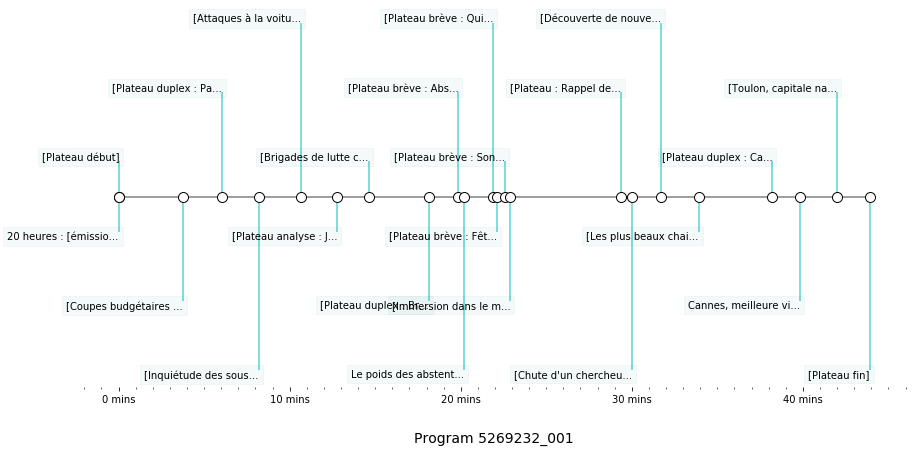

In [15]:
program_id = '5269232_001'

titles = segs[segs['program'] == program_id]['title'].values
times  = segs[segs['program'] == program_id]['start_s'].values
visualize_timeline(times, titles)

# INA: Generating content representations

In [16]:
if os.path.exists('./segments_data.pickle'):
    segments_data = pickle.load(open('./segments_data.pickle', 'rb'))

else:
    segments_data = {}
    for program_id in tqdm(segs.program.unique()):
        segments = segs[(segs['program'] == program_id) & (segs['segment_id'] != program_id)]
        segments_data[program_id] = {'n_segments': len(segments)}
        segments_data[program_id]['start'] = segments.start_s.values.tolist()
        segments_data[program_id]['duration'] = segments.duration_s.values.tolist()
        segments_data[program_id]['end'] = segments.end_s.values.tolist()
        segments_data[program_id]['text'] = segments.title.values.tolist()
        segments_data[program_id]['embeddings'] = sbert.encode(segments.title.str.lower().values.tolist(), convert_to_tensor=True)
    pickle.dump(segments_data, open('./segments_data.pickle', 'wb'))

In [17]:
if os.path.exists('./subtitles_data.pickle'):
    subtitles_data = pickle.load(open('./subtitles_data.pickle', 'rb'))

else:
    subtitles_data = {}
    for program_id in tqdm(subs.program.unique()): # ['5265990_001']: # 
        subtitles = subs[subs['program'] == program_id]
        subtitles_data[program_id] = {'n_subs': len(subtitles)}
        subtitles_data[program_id]['start'] = subtitles.start_s.values.tolist()
        subtitles_data[program_id]['duration'] = subtitles.duration_s.values.tolist()
        subtitles_data[program_id]['end'] = subtitles.end_s.values.tolist()
        subtitles_data[program_id]['text'] = subtitles.content.values.tolist()
        subtitles_data[program_id]['embeddings'] = sbert.encode(subtitles.content.values.tolist(), convert_to_tensor=True)
    pickle.dump(subtitles_data, (open('./subtitles_data.pickle', 'wb'))

In [18]:
sim_with_title = {}

for program_id in tqdm(segs.program.unique()):    
    res = util.pytorch_cos_sim(segments_data[program_id]['embeddings'], subtitles_data[program_id]['embeddings']).numpy()
    sim_with_title[program_id] = res

In [ ]:
subtitles_sim = {}

for program_id in tqdm(segs.program.unique()):    
    res = util.pytorch_cos_sim(subtitles_data[program_id]['embeddings'], subtitles_data[program_id]['embeddings']).numpy()
    subtitles_sim[program_id] = res
    
    fig=plt.figure(figsize=(9,9))
    plt.title(program_id)
    sns.heatmap(subtitles_sim[program_id]).plot()

In [232]:
def visualize_segmentation(segments_starts, titles, hypothesis, scores, program_title=''):
    levels = np.array([-1, 1, -3, 3, -5, 5])
    levels_2 = np.array([-0.5, 0.5, -2.5, 2.5, -4.5, 4.5])
    fig, ax = plt.subplots(figsize=(15, 7))

    # Create the base line
    start = min(min(segments_starts), min(hypothesis))
    stop = max(max(segments_starts), max(hypothesis))

    # Draw the timeline
    ax.plot((start, stop), (0, 0), 'k', alpha=.5)

    # Iterate through releases annotating each one
    for ii, (ititle, itime) in enumerate(zip(titles, segments_starts)):
        ititle = ititle[:20] + ('...' if len(ititle) > 20 else '')
        level = levels[ii % 6]
        vert = 'top' if level < 0 else 'bottom'

        # Draw a circle at the timeline
        ax.scatter(itime, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)

        # Draw a line up to the text
        ax.plot((itime, itime), (0, level), linewidth=2, c='c', alpha=.5)

        # Give the text a faint background and align it properly
        ax.text(itime, level, ititle,
                horizontalalignment='right', verticalalignment=vert, fontsize=10,
                backgroundcolor=(.2, .55, .6, .05))
    
    sub_ids, scores = list(zip(*scores))
    sub_labels = [f'sub_{s} ({i})' for i, s in enumerate(sub_ids)]

    data = sorted(zip(sub_labels, hypothesis), key=lambda x:x[1])
    
    # Iterate through releases annotating each one
    for ii, (ititle, itime) in enumerate(data):
        level = levels_2[ii % 6]
        vert = 'top' if level < 0 else 'bottom'

        # Draw a circle at the timeline
        ax.scatter(itime, 0, s=100, facecolor='w', edgecolor='gold', zorder=9999)

        # Draw a line up to the text
        ax.plot((itime, itime), (0, level), linewidth=2, c=(.92, .2, .4), alpha=.5)

        # Give the text a faint background and align it properly
        ax.text(itime, level, ititle,
                horizontalalignment='right', verticalalignment=vert, fontsize=10,
                backgroundcolor=(.92, .2, .4, .05))

    try:
        major_locator = int(stop / 100) * 10
    except:
        print("Exception")
        print(segments_starts)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(major_locator))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(major_locator / 10))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda tick, pos: str(int(tick/60)) + ' mins'))

    # Remove the figure border and y-axis (levels) components for a cleaner look
    plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
              list(ax.spines.values())), visible=False)
    plt.title(program_id + (' - ' + program_title if program_title else ''), y=-0.16, fontsize=14)
    plt.show()

In [156]:
def process_program(program_id, window_size=3, scoring_method='avg', visualize=True,
                    segs=segs, subtitles_data=subtitles_data, segments_data=segments_data):
    sim_matrix = subtitles_sim[program_id]
    n_segments = segments_data[program_id]['n_segments'] + 1
    N = sim_matrix.shape[0]
    scores_dic = {'avg':[], 'mul':[]}
    
    for i in range(N):
        neighbors = range(i, min(i+window_size, N))
        neighbors_scores = [sim_matrix[i][j] for j in neighbors]
        scores_dic['avg'].append(np.mean(neighbors_scores))
        scores_dic['mul'].append(np.product(neighbors_scores))
    
    scores = scores_dic[scoring_method]
    minima = [(i, score) for i, score in sorted(enumerate(scores), key=lambda x: x[1])]
    minima_starts = [subtitles_data[program_id]['start'][i] for i, s in minima]
    
    titles = segs[segs['program'] == program_id]['title'].values
    times  = segs[segs['program'] == program_id]['start_s'].values
    program_title = segs[segs['segment_id'] == program_id]['title'].values[0]

    if visualize:
        visualize_segmentation(times, titles, minima_starts[:n_segments], minima[:n_segments], program_title)
    
    return times, minima_starts, minima, n_segments

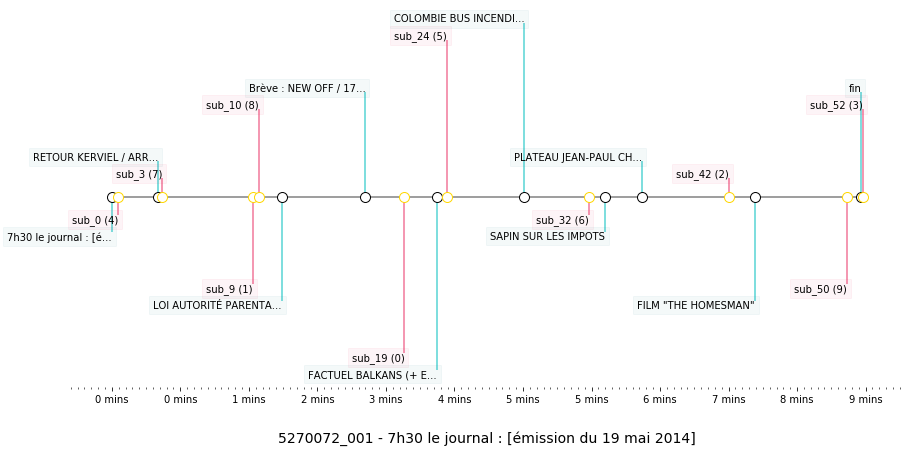

In [157]:
_ = process_program('5265997_001', window_size=3, scoring_method='avg')

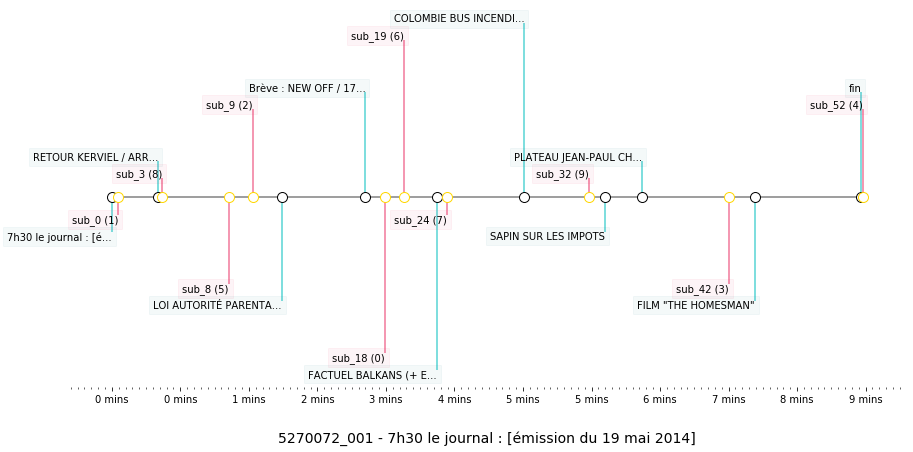

(array([  0.,  34., 124., 185., 237., 301., 360., 387., 469., 547.]),
 [199.14,
  4.72,
  102.81,
  450.29,
  547.96,
  85.36,
  213.41,
  244.43,
  36.9,
  347.97,
  527.48,
  107.35,
  453.05,
  539.95,
  536.6,
  125.54,
  515.16,
  500.62,
  180.14,
  321.96,
  470.71,
  228.71,
  127.89,
  435.35,
  490.76,
  483.16,
  221.47,
  17.48,
  333.22,
  389.91,
  218.65,
  249.52,
  549.94,
  157.43,
  225.05,
  8.61,
  166.04,
  39.46,
  361.46,
  188.39,
  353.33,
  145.59,
  379.82,
  415.64,
  398.81,
  272.86,
  78.58,
  253.45,
  55.73,
  413.19,
  303.35,
  428.95,
  66.4,
  288.53,
  554.97],
 [(18, -0.0041507985),
  (0, -0.0030255693),
  (9, -0.00017032355),
  (42, -2.7086714e-06),
  (52, 9.634854e-05),
  (8, 0.00030755752),
  (19, 0.00057184795),
  (24, 0.00076064735),
  (3, 0.0013962552),
  (32, 0.002862308),
  (49, 0.003107988),
  (10, 0.006007055),
  (43, 0.0060175736),
  (51, 0.006521559),
  (50, 0.009332026),
  (11, 0.009530245),
  (48, 0.009975029),
  (47, 0.010584936),


In [158]:
process_program('5265997_001', window_size=3, scoring_method='mul')

# Metrics

In [159]:
from nltk.metrics.segmentation import pk, windowdiff

In [160]:
def compute_metrics(program_id, window_size=3, k=50, scoring_method='avg'):
    gt_times, hypo_times, scores, n_segments = process_program(program_id, window_size=window_size, 
                                                               scoring_method=scoring_method, visualize=False)
    duration = int(segs[segs.segment_id == program_id]['duration_s'].values[0])
    duration = max(duration, int(max(gt_times))) + 1
    
    seg_true = ['0'] * duration
    seg_hypo = ['0'] * duration
    
    # assert(int(max(gt_times)) <= duration)
    
    for i in range(n_segments):
        try:
            seg_true[int(gt_times[i])] = '1'
            seg_hypo[int(hypo_times[i])] = '1'
        except:
            print(program_id, gt_times, n_segments)

    for i in range(len(hypo_times)):
        seg_hypo[int(hypo_times[i])] = '1'
    
    seg_true = ''.join(seg_true)
    seg_hypo = ''.join(seg_hypo)
    
    print(program_id)
    print('Pk:         ', pk(seg_true, seg_hypo, k))
    print('WindowDiff: ', windowdiff(seg_true, seg_hypo, k))

In [161]:
segs[segs.segment_id != segs.program]['duration_s'].mean()

83.57790368271955

In [172]:
for program_id in unique_programs:
    compute_metrics(program_id,  k=3)

5265990_001
Pk:          0.233201581027668
WindowDiff:  0.23715415019762845
5265994_001
Pk:          0.33907056798623064
WindowDiff:  0.3407917383820998
5265997_001
Pk:          0.29695885509839
WindowDiff:  0.29874776386404295
5266001_001
Pk:          0.28267045454545453
WindowDiff:  0.28267045454545453
5266025_001
Pk:          0.2967315460888726
WindowDiff:  0.2967315460888726
5266045_001
Pk:          0.27309893704006544
WindowDiff:  0.2739165985282093
5266511_001
Pk:          0.2867383512544803
WindowDiff:  0.2867383512544803
5266515_001
Pk:          0.2663115845539281
WindowDiff:  0.2663115845539281
5266518_001
Pk:          0.3379721669980119
WindowDiff:  0.3379721669980119
5266522_001
Pk:          0.31736526946107785
WindowDiff:  0.3188622754491018
5266546_001
Pk:          0.3845299777942265
WindowDiff:  0.3845299777942265
5266565_001
Pk:          0.3275020341741253
WindowDiff:  0.3279088689991863
5266890_001
Pk:          0.025016789791806583
WindowDiff:  0.025016789791806583
5266

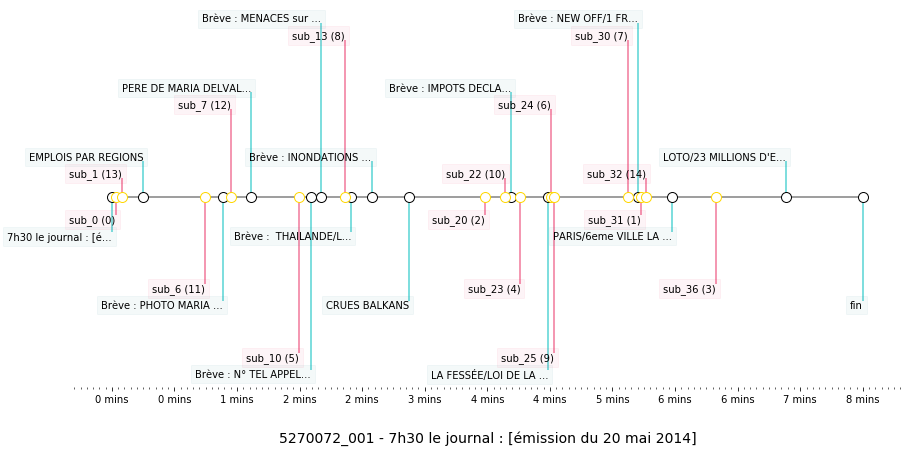

In [163]:
_ = process_program('5266518_001', window_size=3, scoring_method='avg')

In [173]:
compute_metrics('5266518_001',  k=3)

5266518_001
Pk:          0.3379721669980119
WindowDiff:  0.3379721669980119


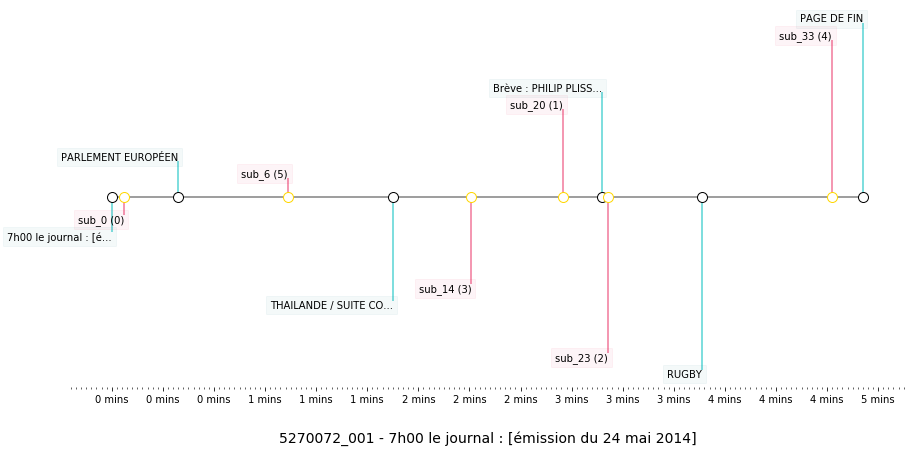

In [164]:
_ = process_program('5269476_001', window_size=3, scoring_method='avg')

In [168]:
compute_metrics('5269476_001',  k=42)

5269476_001
Pk:          0.39015151515151514
WindowDiff:  1.0


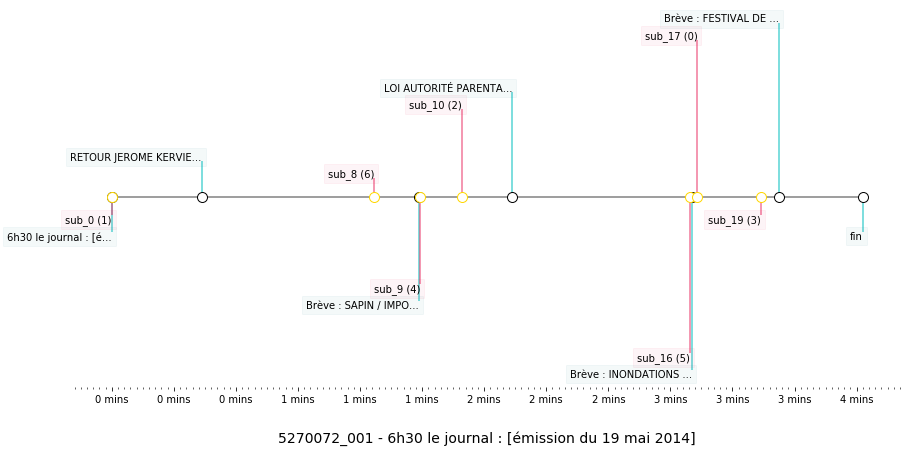

In [165]:
_ = process_program('5265990_001', window_size=3, scoring_method='avg')

In [169]:
compute_metrics('5265990_001',  k=42)

5265990_001
Pk:          0.205607476635514
WindowDiff:  0.9906542056074766


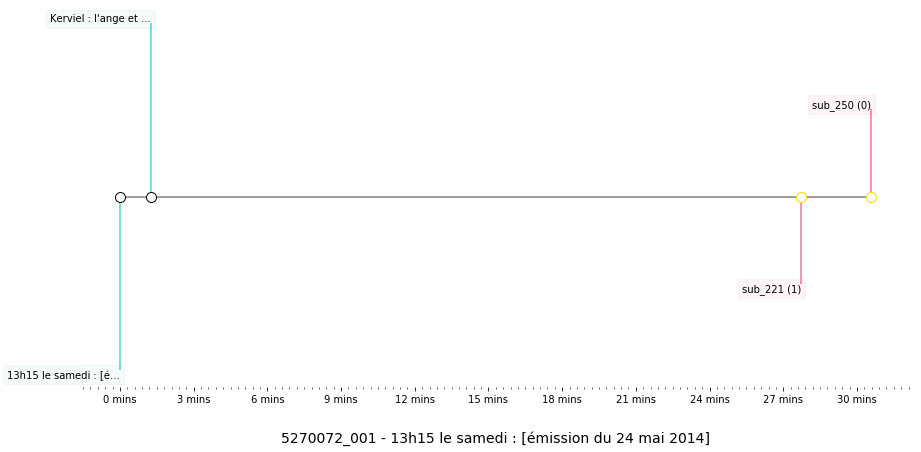

In [170]:
_ = process_program('5269507_001', window_size=3, scoring_method='avg')

In [171]:
compute_metrics('5269507_001',  k=42)

5269507_001
Pk:          0.9773445732349842
WindowDiff:  1.0


In [166]:
segs[segs.segment_id == '5270036_001']

,segment_id,program,title,start,duration,start_s,duration_s,end_s,has_parts
671,5270036_001,5270036_001,8h00 le journal : [émission du 26 mai 2014],00:00:00,00:12:43,0.0,763.0,763.0,True


# Yle: Generating content representations

In [212]:
subs = pd.read_csv('data/yle_subtitles/urheiluruutu_subs.csv')
segs = pd.read_csv('data/yle_subtitles/urheiluruutu_segs.csv').sort_values(['program', 'start_s'])

In [213]:
segs.head()

,segment_id,program,title,start,duration,start_s,duration_s,end_s
0,4e2526e14df4c791284d21bd20d0ac61ec02263a,PROG_2020_00823730,Kreikkalais-roomalaisen painin kotimainen kärk...,00:00:14.160,00:02:04.640,14.16,124.64,138.80
1,732dab4376ec366ecd3fd8245c9a84fe7448d162,PROG_2020_00823730,Jääkiekon SM-liigan peliä (Cmore). Puhelinhaa...,00:02:18.840,00:00:56.920,138.84,56.92,195.76
58,PROG_2020_00823730,PROG_2020_00823730,Urheiluruutu,NaN,279.2,NaN,279.20,NaN
3,48c892139422bc4a573b35ffffd9b38d1dbcffc8,PROG_2020_00823804,Kalervo Kummola (SU-) puhelinhaast.,00:00:10.440,00:00:56.080,10.44,56.08,66.52
2,483e5e166fd387a117410f4fac887212ad4293c5,PROG_2020_00823804,Suomen Cupissa Vantaalla hiihdetään lumipyryss...,00:01:06.560,00:02:05.520,66.56,125.52,192.08


In [214]:
segs.program.unique()

array(['PROG_2020_00823730', 'PROG_2020_00823804', 'PROG_2020_00823937',
       'PROG_2020_00823938', 'PROG_2020_00824011', 'PROG_2020_00824065',
       'PROG_2020_00824117', 'PROG_2020_00824170', 'PROG_2020_00824275',
       'PROG_2020_00824315', 'PROG_2020_00824381', 'PROG_2020_00824382'],
      dtype=object)

In [220]:
if not os.path.exists('./segments_data_yle.pickle'):
    segments_data = pickle.load(open('./segments_data_yle.pickle', 'rb'))

else:
    segments_data = {}
    for program_id in tqdm(segs.program.unique()):
        try:
            segments = segs[(segs['program'] == program_id) & (segs['segment_id'] != program_id)]
            segments_data[program_id] = {'n_segments': len(segments)}
            segments_data[program_id]['start'] = segments.start_s.values.tolist()
            segments_data[program_id]['duration'] = segments.duration_s.values.tolist()
            segments_data[program_id]['end'] = segments.end_s.values.tolist()
            segments_data[program_id]['text'] = segments.title.values.tolist()
            segments_data[program_id]['embeddings'] = sbert.encode(segments.title.str.lower().values.tolist(), convert_to_tensor=True)
        except Exception as e:
            print(program_id, str(e))
    pickle.dump(segments_data, open('./segments_data_yle.pickle', 'wb'))

PROG_2020_00824170 stack expects a non-empty TensorList



In [219]:
if not os.path.exists('./subtitles_data_yle.pickle'):
    subtitles_data = pickle.load(open('./subtitles_data_yle.pickle', 'rb'))

else:
    subtitles_data = {}
    for program_id in tqdm(subs.program.unique()): # ['5265990_001']: # 
        subtitles = subs[subs['program'] == program_id]
        subtitles_data[program_id] = {'n_subs': len(subtitles)}
        subtitles_data[program_id]['start'] = subtitles.start_s.values.tolist()
        subtitles_data[program_id]['duration'] = subtitles.duration_s.values.tolist()
        subtitles_data[program_id]['end'] = subtitles.end_s.values.tolist()
        subtitles_data[program_id]['text'] = subtitles.content.values.tolist()
        subtitles_data[program_id]['embeddings'] = sbert.encode(subtitles.content.values.tolist(), convert_to_tensor=True)
    pickle.dump(subtitles_data, open('./subtitles_data_yle.pickle', 'wb'))

In [223]:
sim_with_title = {}

for program_id in tqdm(segs.program.unique()):    
    try:
        res = util.pytorch_cos_sim(segments_data[program_id]['embeddings'], subtitles_data[program_id]['embeddings']).numpy()
        sim_with_title[program_id] = res
    except Exception as e:
        print(program_id, str(e))

PROG_2020_00824170 'embeddings'



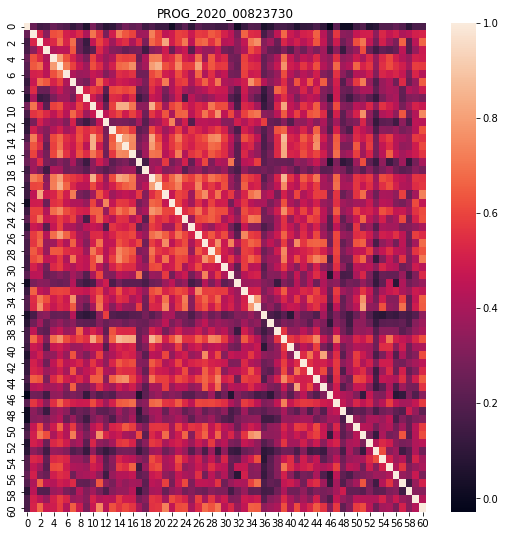

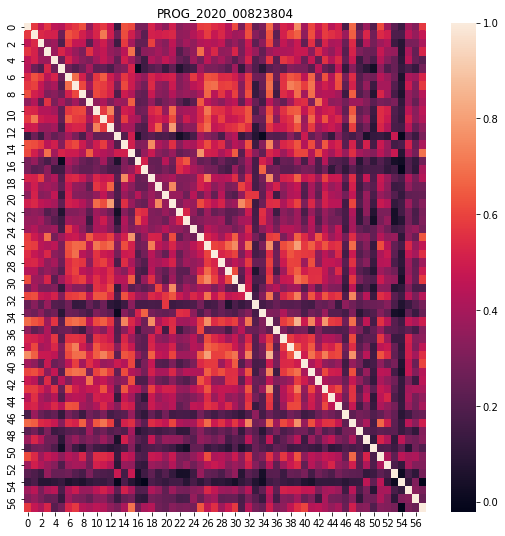

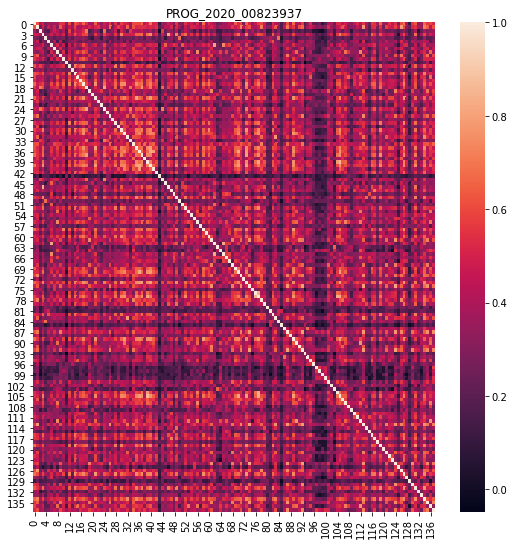

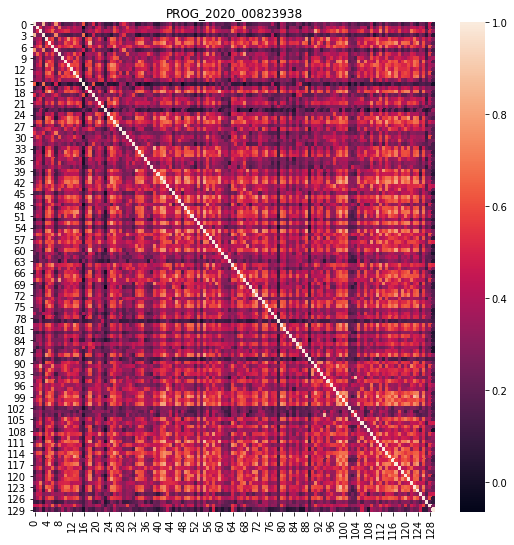

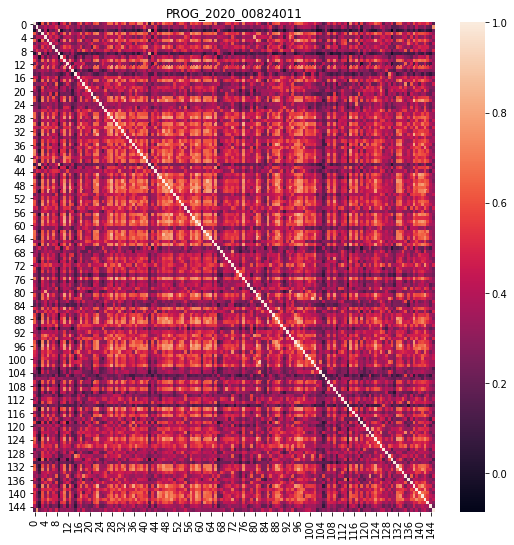

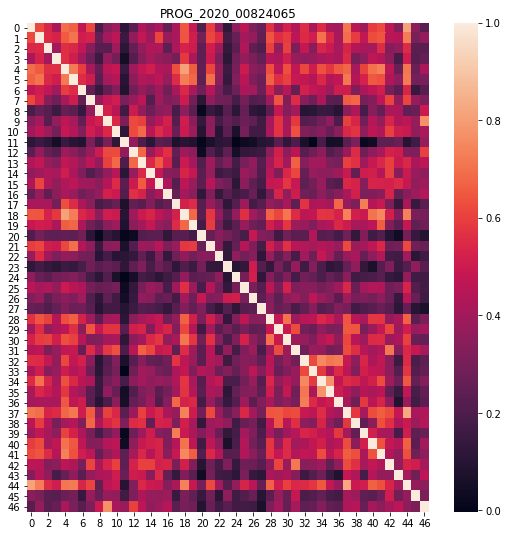

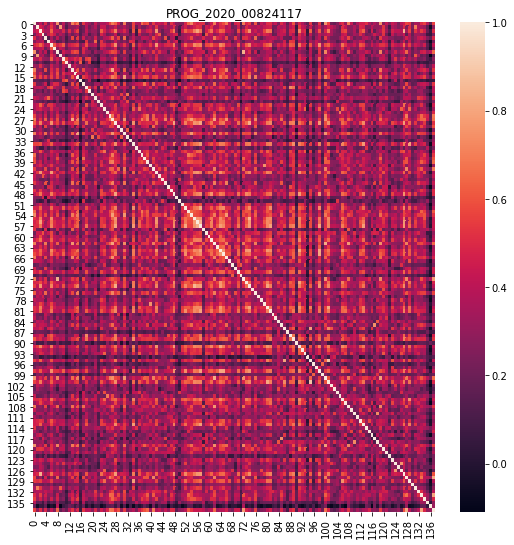

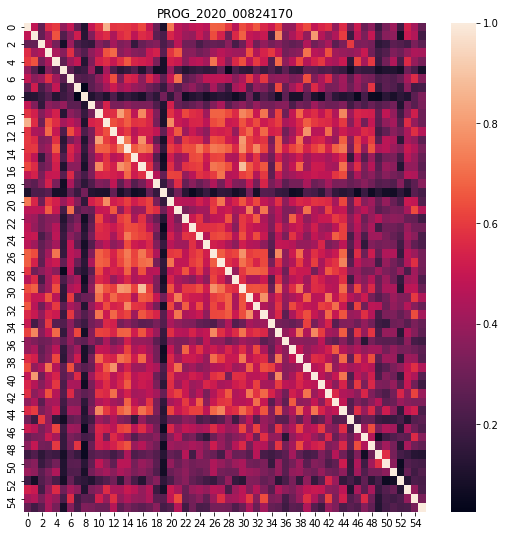

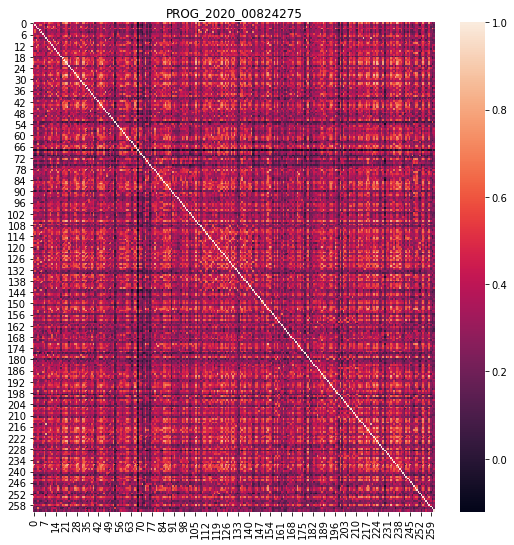

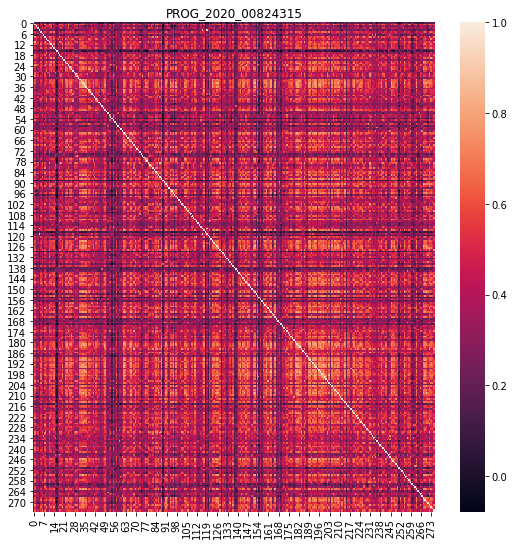

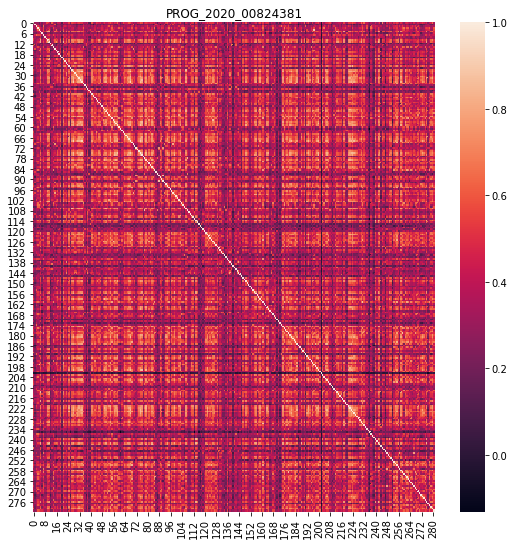

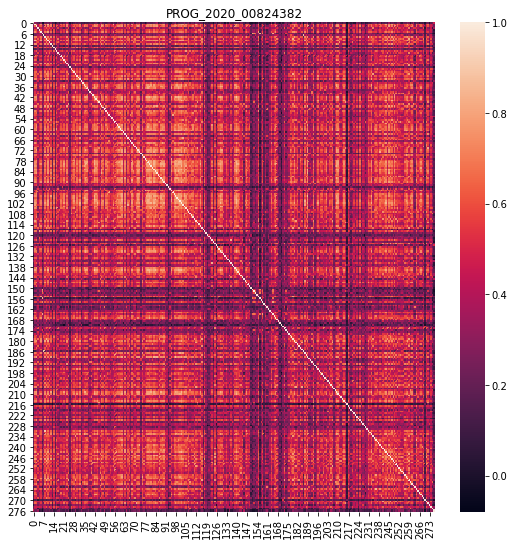

In [224]:
subtitles_sim = {}

for program_id in tqdm(segs.program.unique()):    
    res = util.pytorch_cos_sim(subtitles_data[program_id]['embeddings'], subtitles_data[program_id]['embeddings']).numpy()
    subtitles_sim[program_id] = res
    
    fig=plt.figure(figsize=(9,9))
    plt.title(program_id)
    sns.heatmap(subtitles_sim[program_id]).plot()

PROG_2020_00823730


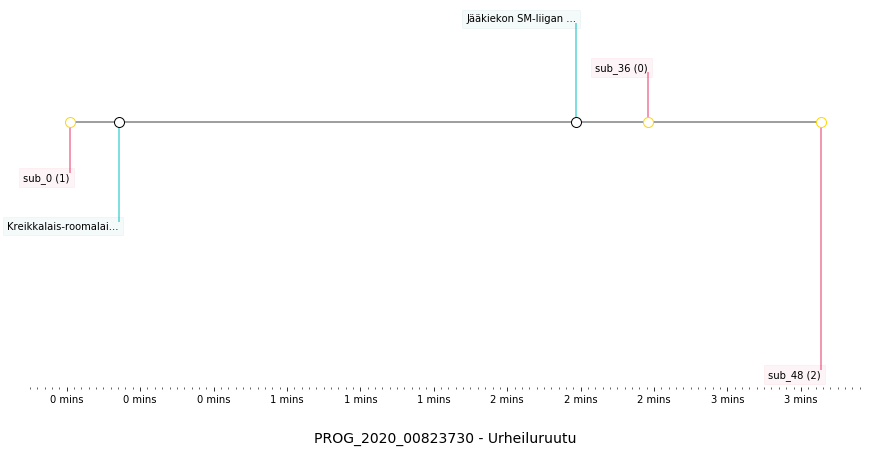

PROG_2020_00823804


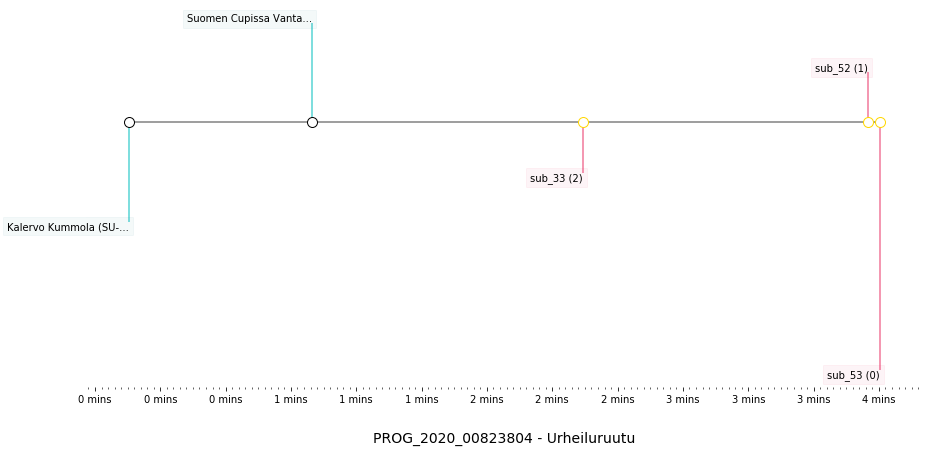

PROG_2020_00823937


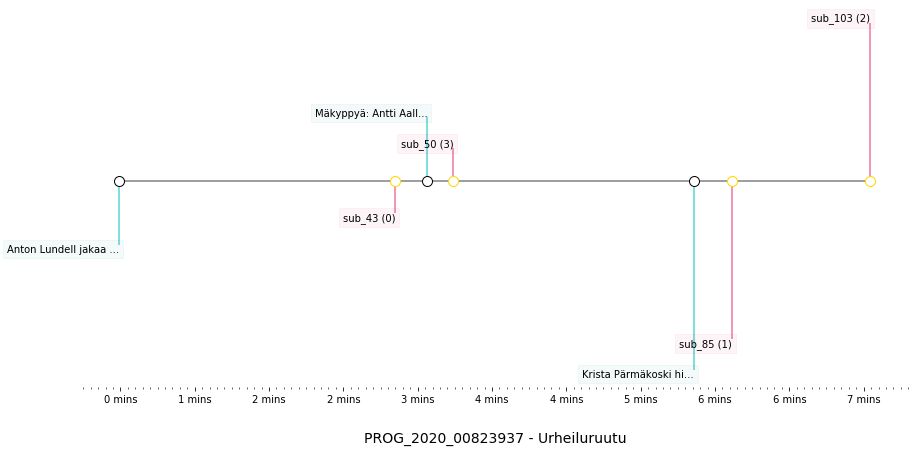

PROG_2020_00823938


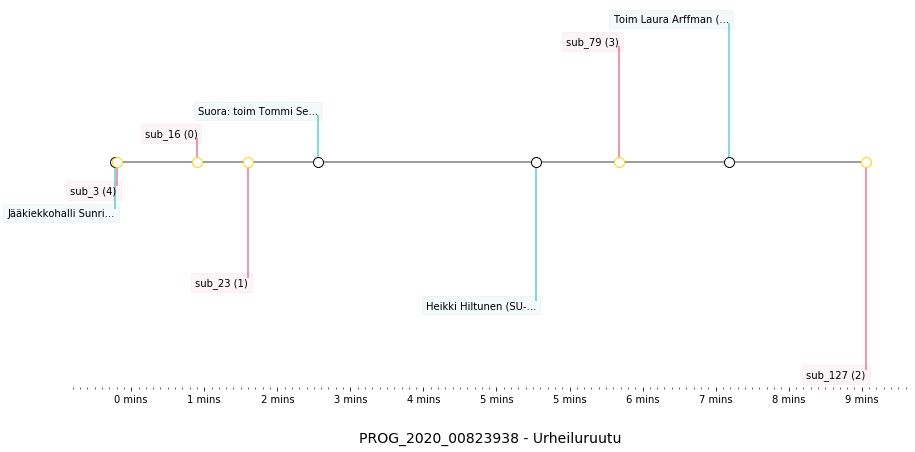

PROG_2020_00824011


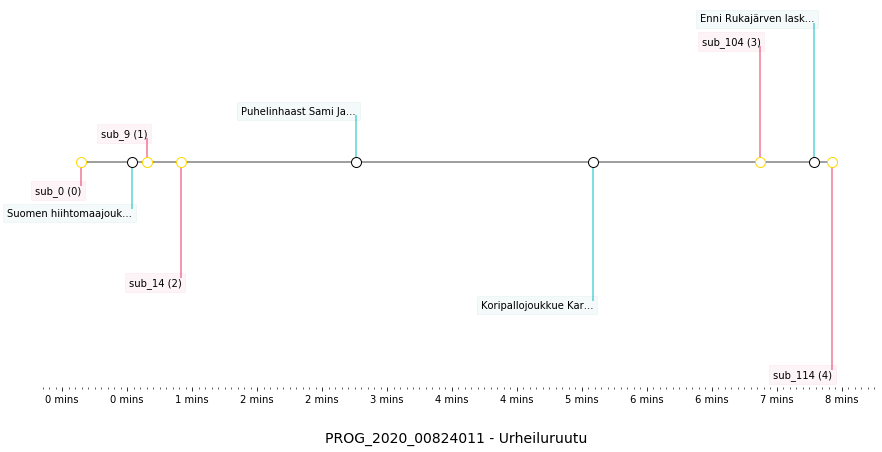

PROG_2020_00824065


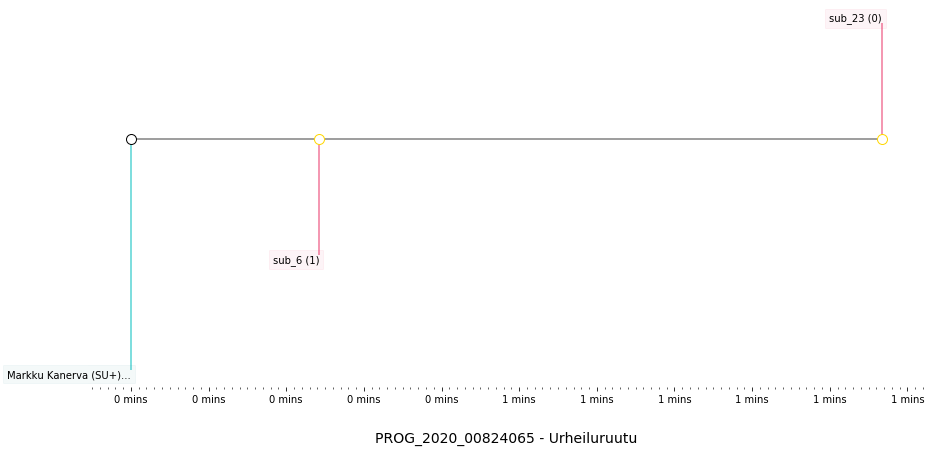

PROG_2020_00824117


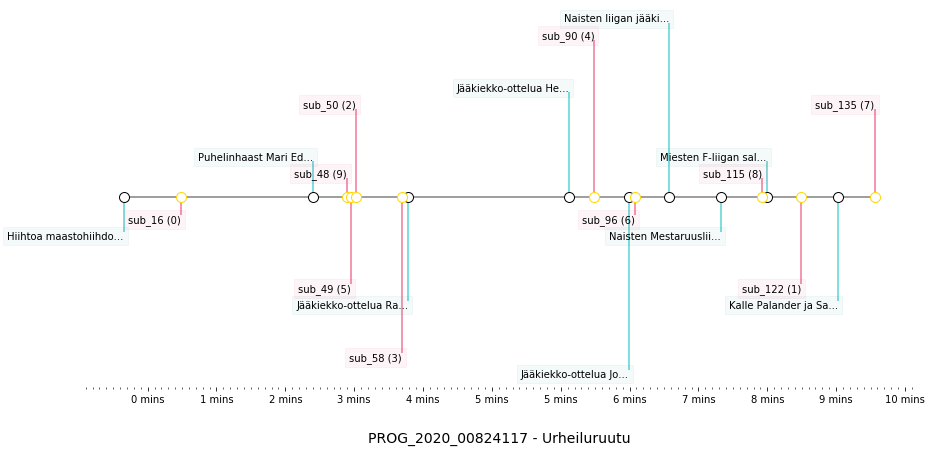

PROG_2020_00824170
Exception
[nan]
PROG_2020_00824170
PROG_2020_00824275


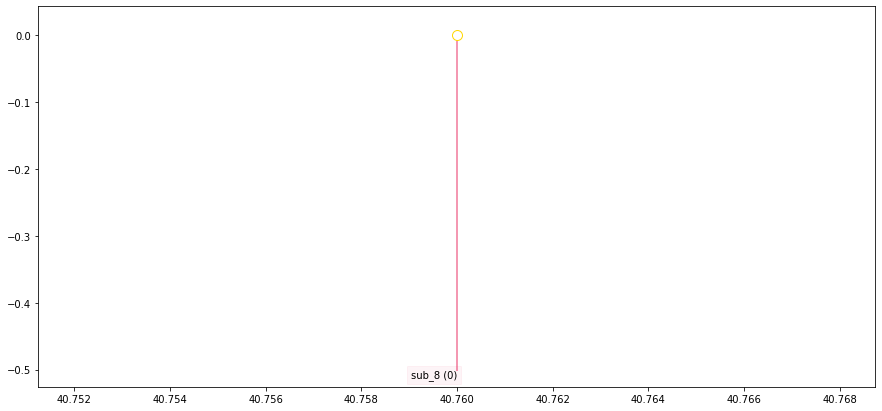

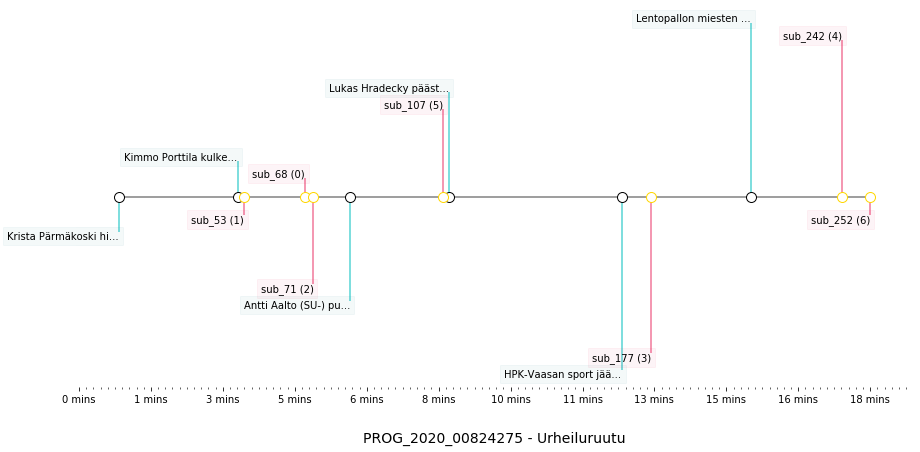

PROG_2020_00824315


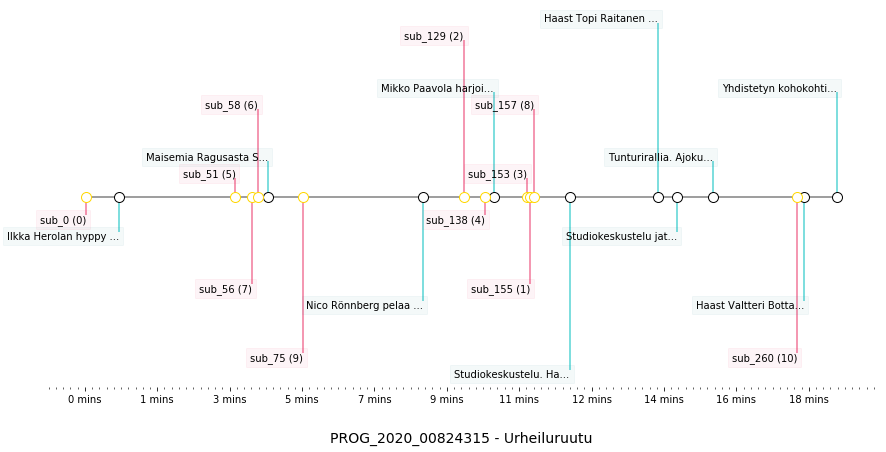

PROG_2020_00824381


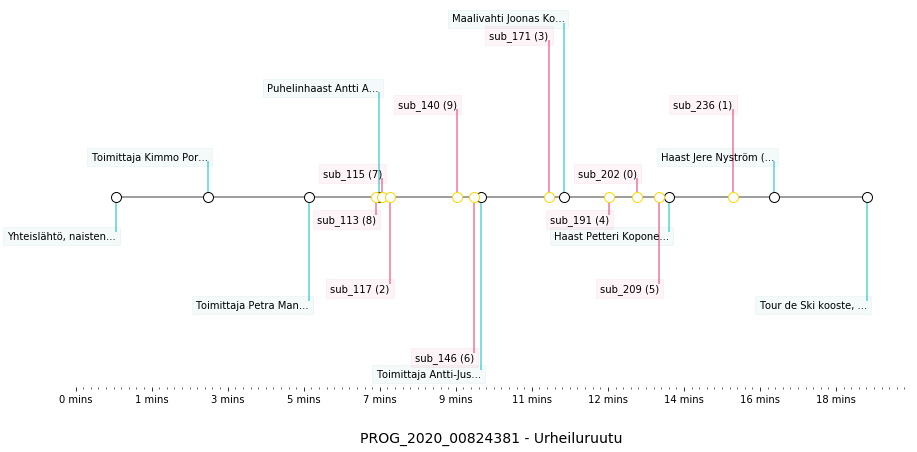

PROG_2020_00824382


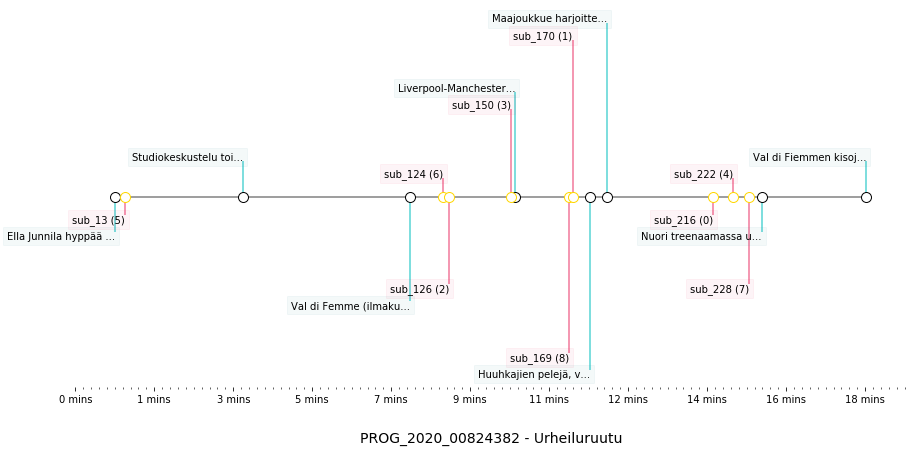

In [234]:
for program_id in segs.program.unique():
    print(program_id)
    try:
        process_program(program_id, window_size=3, scoring_method='avg', segs=segs, subtitles_data=subtitles_data, segments_data=segments_data)
    except:
        print(program_id)

In [226]:
segments_data['PROG_2020_00823937']['n_segments']

3

In [227]:
segs[segs['segment_id'] == 'PROG_2020_00823937']['title'].values[0]

'Urheiluruutu'

In [235]:
segments_data_jorma = {}
for key in segments_data:
    segments_data_jorma[key] = {}
    segments_data_jorma[key]['start'] = segments_data[key]['start']
    segments_data_jorma[key]['end'] = segments_data[key]['end']

In [236]:
segs[segs['program'] == 'PROG_2020_00823938']

,segment_id,program,title,start,duration,start_s,duration_s,end_s
10,b2806824561288de7f2ea47e72247676551a42ce,PROG_2020_00823938,"Jääkiekkohalli Sunrisessa, Floridassa (ulko, s...",00:00:38.600,00:02:19.120,38.60,139.12,177.72
9,9b4b3066468437c8d1f1885fdc1e143ab6d52de4,PROG_2020_00823938,Suora: toim Tommi Seppälä (SU+) selostaa. Dall...,00:02:57.760,00:02:29.560,177.76,149.56,327.32
8,1934354ad2233b7e19c202fb7f02f422aee24b67,PROG_2020_00823938,Heikki Hiltunen (SU-) puhelinhaast.,00:05:27.360,00:00:28.640,327.36,28.64,356.00
7,0850e92d52ee1796771ef9c6df15ea362225ab8c,PROG_2020_00823938,Toim Laura Arffman (SU+) selostaa. Sami Jauhoj...,00:07:39.320,00:01:29.520,459.32,89.52,548.84
61,PROG_2020_00823938,PROG_2020_00823938,Urheiluruutu,NaN,573.15,NaN,573.15,NaN


In [237]:
segments_data_jorma

{'PROG_2020_00823730': {'start': [14.16, 138.84], 'end': [138.8, 195.76]},
 'PROG_2020_00823804': {'start': [10.44, 66.56], 'end': [66.52, 192.08]},
 'PROG_2020_00823937': {'start': [39.44, 205.16, 348.64],
  'end': [183.76, 348.6, 478.0]},
 'PROG_2020_00823938': {'start': [38.6, 177.76, 327.36, 459.32],
  'end': [177.72, 327.32, 356.0, 548.84]},
 'PROG_2020_00824011': {'start': [43.0, 180.92, 326.96, 463.24],
  'end': [180.88, 279.04, 400.96, 586.32]},
 'PROG_2020_00824065': {'start': [10.0], 'end': [83.84]},
 'PROG_2020_00824117': {'start': [32.52,
   170.16,
   239.28,
   356.32,
   399.24,
   428.8,
   466.32,
   499.52,
   551.68],
  'end': [170.12,
   239.24,
   356.28,
   399.2,
   428.76,
   453.28,
   499.48,
   529.04,
   592.4]},
 'PROG_2020_00824170': {'start': [], 'end': []},
 'PROG_2020_00824275': {'start': [55.4, 220.68, 377.36, 514.92, 754.24, 934.4],
  'end': [220.64, 377.32, 433.92, 649.4, 879.0, 1102.9189999999999]},
 'PROG_2020_00824315': {'start': [52.56,
   277.96

In [238]:
subtitles_data_jorma = {}
for key in segments_data:
    subtitles_data_jorma[key] = {}
    subtitles_data_jorma[key]['start'] = subtitles_data[key]['start']
    subtitles_data_jorma[key]['end'] = subtitles_data[key]['end']
    subtitles_data_jorma[key]['duration'] = subtitles_data[key]['duration']

In [239]:
pickle.dump(subtitles_data_jorma, open('yle_subtitles_timestamps.pickle', 'wb'))
pickle.dump(segments_data_jorma, open('yle_parts_timestamps.pickle', 'wb'))

In [242]:
pickle.dump(subtitles_sim, open('yle_subtitle_neighborhood_similarity.pickle', 'wb'))